In [1]:
#tugas 1

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigDataWeek9").getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

25/10/26 15:30:19 WARN Utils: Your hostname, OSSalwa resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/10/26 15:30:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/26 15:30:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/26 15:30:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+



+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+



[Stage 4:===========================================================(2 + 0) / 2]

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [2]:
#tugas 2
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

[Stage 7:>                                                          (0 + 2) / 2]

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [3]:
# tugas tambahan

# 1. rata-rata gaji per departemen
spark.sql('''
SELECT DeptId, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').show()

[Stage 10:>                                                         (0 + 2) / 2]

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [4]:
# 2. karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.

spark.sql('''
WITH avg_gender AS (
    SELECT Gender, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Gender
)
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN avg_gender g ON e.Gender = g.Gender
WHERE e.Salary > g.AvgSalary
ORDER BY e.Gender, e.Salary DESC
''').show()


[Stage 14:=============================>                            (1 + 1) / 2]

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+



In [5]:
# 3. ranking karyawan berdasarkan gaji dalam departemen mereka

spark.sql('''
SELECT 
    Name, 
    DeptId, 
    Salary,
    RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankInDept
FROM employees
ORDER BY DeptId, RankInDept
''').show()

+-----+------+------+----------+
| Name|DeptId|Salary|RankInDept|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



In [6]:
# tugas 3 menampilkan karyawan dengan gaji tertinggi dan urutannya berdasarkan kelompok usia

spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

[Stage 21:>                                                         (0 + 2) / 2]

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [7]:
# tugas 3 menemukan top 3 karyawan dalam tiap kelo ppk tertentu

spark.sql('''
WITH ranked AS (
    SELECT 
        Name, 
        Age, 
        Salary, 
        ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) AS rank
    FROM employees
)
SELECT * 
FROM ranked
WHERE rank <= 3
ORDER BY Age, rank
''').show()

[Stage 24:>                                                         (0 + 2) / 2]

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [8]:
# tugas 4: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

25/10/26 15:31:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



In [9]:
# tugas 5: menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji

spark.sql('''
WITH ranked AS (
    SELECT 
        e.Name,
        d.DeptName,
        e.Salary,
        ROUND(AVG(e.Salary) OVER (PARTITION BY d.DeptName), 2) AS AvgSalary,
        RANK() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) AS RankInDept
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
)
SELECT *
FROM ranked
ORDER BY DeptName, RankInDept
''').show()

[Stage 36:>                                                         (0 + 2) / 2]

+-----+---------+------+---------+----------+
| Name| DeptName|Salary|AvgSalary|RankInDept|
+-----+---------+------+---------+----------+
|James|       HR|  3000|   2850.0|         1|
|  Lee|       HR|  2700|   2850.0|         2|
| Anna|Marketing|  4100|   4100.0|         1|
+-----+---------+------+---------+----------+



In [10]:
# tugas 6: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.

spark.sql('''
WITH salary_trend AS (
    SELECT 
        d.DeptName,
        e.Name,
        e.Age,
        e.Salary,
        LAG(e.Salary) OVER (PARTITION BY d.DeptName ORDER BY e.Age) AS PrevSalary,
        (e.Salary - LAG(e.Salary) OVER (PARTITION BY d.DeptName ORDER BY e.Age)) AS SalaryChange
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
)
SELECT *,
       CASE 
           WHEN SalaryChange > 0 THEN 'Naik'
           WHEN SalaryChange < 0 THEN 'Turun'
           ELSE 'Stabil'
       END AS Trend
FROM salary_trend
ORDER BY DeptName, Age
''').show()

[Stage 45:>                                                         (0 + 2) / 2]

+---------+-----+---+------+----------+------------+------+
| DeptName| Name|Age|Salary|PrevSalary|SalaryChange| Trend|
+---------+-----+---+------+----------+------------+------+
|       HR|  Lee| 23|  2700|      NULL|        NULL|Stabil|
|       HR|James| 34|  3000|      2700|         300|  Naik|
|Marketing| Anna| 28|  4100|      NULL|        NULL|Stabil|
+---------+-----+---+------+----------+------------+------+



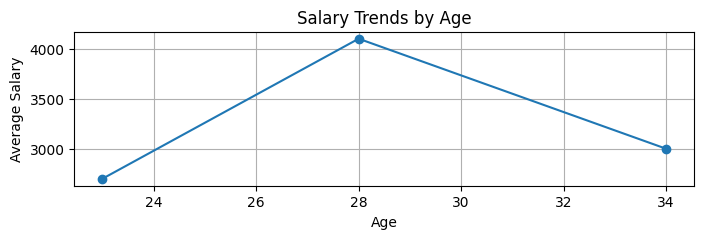

In [13]:
# tugas 7: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.

import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(8, 2))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

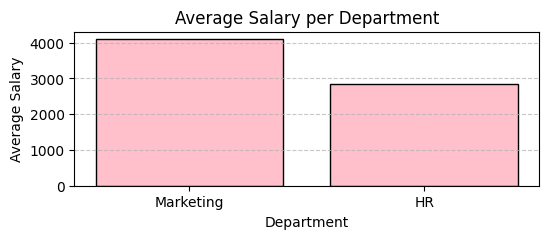

In [27]:
# Homework Tugas 1

# Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen
dept_analysis = spark.sql('''
SELECT d.DeptName,
       COUNT(e.Name) AS TotalEmployees,
       AVG(e.Salary) AS AverageSalary,
       SUM(e.Salary) AS TotalSalary
FROM employees e
JOIN departments d
ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY AverageSalary DESC
''').toPandas()

# Visualisasi perbandingan rata-rata gaji antar departemen (vertikal)
plt.figure(figsize=(6, 2))
plt.bar(dept_analysis['DeptName'], dept_analysis['AverageSalary'], color='pink', edgecolor='black')
plt.xlabel('Department')
plt.ylabel('Average Salary')
plt.title('Average Salary per Department')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

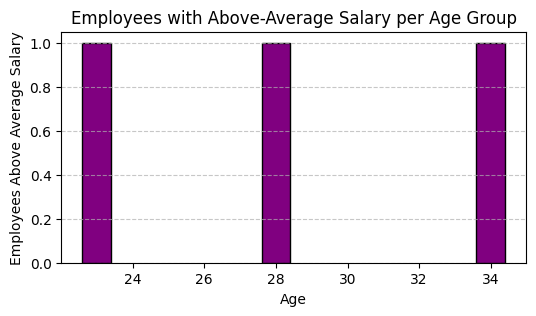

In [33]:
# Homework Tugas 2: Cari karyawan dengan gaji di atas rata-rata di kelompok usianya

# tambahkan data
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Sofia', 34, 'F', 3500, 2),
    ('David', 28, 'M', 3900, 1),
    ('Emma', 23, 'F', 3100, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
employees.createOrReplaceTempView('employees')

# Query SQL
above_avg = spark.sql('''
SELECT e.Name, e.Age, e.Salary
FROM employees e
JOIN (
    SELECT Age, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Age
) a ON e.Age = a.Age
WHERE e.Salary > a.AvgSalary
''').toPandas()

# Hitung jumlah karyawan di atas rata-rata per usia
counts = above_avg.groupby('Age').size().reset_index(name='Count')

# Visualisasi dalam bentuk grafik batang
plt.figure(figsize=(6, 3))
plt.bar(counts['Age'], counts['Count'], color='purple', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Employees Above Average Salary')
plt.title('Employees with Above-Average Salary per Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

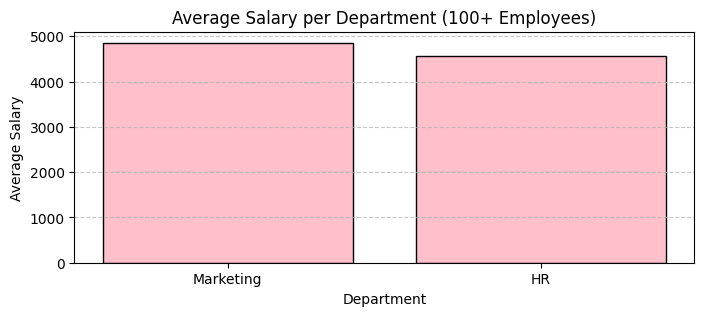

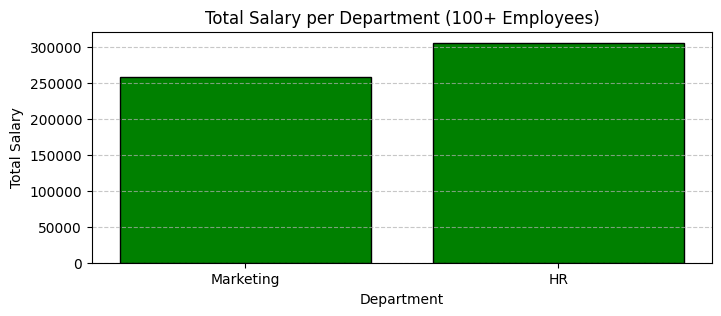

In [37]:
# Homework tugas 3: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti SUM(), AVG(), COUNT(), serta JOIN antar tabel serta buat visualisasi yang menarik.

from pyspark.sql import Row
import random

# Buat dataset employees besar (100+ baris)
names = ['James', 'Anna', 'Lee', 'Michael', 'Sofia', 'David', 'Emma', 'John', 'Mia', 'Robert']
dept_ids = [1, 2]
data = []

for i in range(120):  # 120 baris
    name = random.choice(names)
    age = random.randint(21, 50)
    gender = random.choice(['M', 'F'])
    salary = random.randint(2500, 7000)
    dept = random.choice(dept_ids)
    data.append(Row(Name=name, Age=age, Gender=gender, Salary=salary, DeptId=dept))

employees_big = spark.createDataFrame(data)
employees_big.createOrReplaceTempView('employees_big')

# Analisis mendalam dengan JOIN dan fungsi SQL
dept_analysis_big = spark.sql('''
SELECT d.DeptName,
       COUNT(e.Name) AS TotalEmployees,
       AVG(e.Salary) AS AverageSalary,
       SUM(e.Salary) AS TotalSalary
FROM employees_big e
JOIN departments d
ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY AverageSalary DESC
''').toPandas()

# Visualisasi perbandingan rata-rata gaji antar departemen
plt.figure(figsize=(8, 3))
plt.bar(dept_analysis_big['DeptName'], dept_analysis_big['AverageSalary'], color='pink', edgecolor='black')
plt.xlabel('Department')
plt.ylabel('Average Salary')
plt.title('Average Salary per Department (100+ Employees)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualisasi total gaji per departemen
plt.figure(figsize=(8, 3))
plt.bar(dept_analysis_big['DeptName'], dept_analysis_big['TotalSalary'], color='green', edgecolor='black')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department (100+ Employees)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()